# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Introduction to Data Science

## Lab 10: Transformers in HuggingFace [Draft]

**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
**Authors**: Chris Gumb, Shivas Jayaram, and Guangya Wan

<br/>
---

## 📝 Make a Copy to Edit

This notebook is **view-only**. To edit it, follow these steps:

1. Click **File** > **Save a copy in Drive**.
2. Your own editable copy will open in a new tab.

Now you can modify and run the code freely!

## Learning Objectives

By the end of this Lab, you will understand:
* **HuggingFace** Library and popular **BERT** architecture in **Transformer** library
* Basic Functionality of the **Transformer** library
* An example for a **Text Classification** task using **Pre-trained BERT** including fine-tuning with  **Keras** (**Super Relevant to HW6!!**)
* **Extras**: How to use **GPT2** (Generative Pre-Training) for language generation tasks and how to fine-tune on a custom dataset

In [ ]:
# %%capture
# !pip install --upgrade transformers
# !pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
# Import necessary libraries
import os
import time
import datetime
import requests
import json
import re
import random
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, GPT2Config

from transformers import AutoTokenizer

from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
time_start = time.time()

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Hugging Face and Transformer Overview


Hugging Face is an AI research organization and company that focuses on natural language processing (NLP) and natural language understanding (NLU). They are best known for their open-source Transformers library, which is a widely-used, state-of-the-art library for building, training, and deploying transformer-based models. Hugging Face has contributed significantly to the NLP community by providing user-friendly APIs, pre-trained models, and extensive documentation, making it easier for researchers, developers, and practitioners to work with transformer models.

The Transformers library, initially released in 2019, provides a comprehensive collection of transformer architectures, such as BERT, GPT, RoBERTa, T5, and many others. The library supports both PyTorch and TensorFlow deep learning frameworks, enabling users to seamlessly switch between them. It also offers a wide range of pre-trained models for various NLP tasks, including text classification, named entity recognition, question answering, and more.

One of the key features of the Transformers library is its focus on usability and ease of integration. It offers simple APIs for tokenization, model training, fine-tuning, and inference, along with many useful utilities for handling datasets and evaluation metrics. The library is continually updated and maintained by Hugging Face, with active community contributions, which helps keep it at the forefront of NLP research and development.

Refer to the docs for more information: https://huggingface.co/docs

---
### 🔑 Getting Access to Gated Models (e.g., LLaMA 3) on Hugging Face

To use powerful models like Meta's **LLaMA 3**, you need to:

1. **Create a free Hugging Face account**  
   👉 https://huggingface.co/join

2. **Request access to gated models**  
   Visit the model page (e.g., [LLaMA 3](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)) and click **"Request Access"**.  

3. **Generate a personal access token**  
   - Go to https://huggingface.co/settings/tokens  
   - Click **"New token"**, give it a name (e.g., `colab_token`), and select **"Read"** permissions.  
   - Copy the token somewhere safe!
---
**💡NOTE FOR HW5**

You’ll need an HF account, token, and access LLaMA 3 for the final homework assignment. Access can take a few days to be granted, **so please request it today**.

---
### 🔐 Logging In to Hugging Face from Your Notebook

In Colab (or Jupyter), you can authenticate using your token like this:

```python
from huggingface_hub import notebook_login

# This will prompt you to paste your token in a secure input field
notebook_login()
```
---

# Pretrained Model: BERT vs DistilBERT vs DeBERTa

**BERT (Bidirectional Encoder Representations from Transformers)**, **DistilBERT**, and **DeBERTa (Decoding-enhanced BERT with disentangled attention)** are all state-of-the-art transformer-based models for natural language processing tasks. Here's a brief introduction to each model and a comparison of their characteristics:

1. **BERT (Bidirectional Encoder Representations from Transformers)**:
Introduced by Google AI in 2018, BERT revolutionized NLP by employing bidirectional context in the self-attention mechanism of transformers. BERT is pre-trained on large text corpora using masked language modeling (MLM) and next sentence prediction (NSP) tasks, making it capable of understanding context and generating high-quality embeddings. BERT can be fine-tuned for various downstream tasks such as text classification, named entity recognition, and question answering.

2. **DistilBERT**:
DistilBERT, developed by Hugging Face, is a smaller, faster, and more efficient version of BERT. It is created using knowledge distillation, a technique that transfers knowledge from a larger teacher model (in this case, BERT) to a smaller student model (DistilBERT). DistilBERT retains about 95% of BERT's performance while having only 50% of its parameters, which makes it more suitable for deployment in resource-constrained environments or real-time applications.

3. **DeBERTa (Decoding-enhanced BERT with disentangled attention)**:
Introduced by Microsoft Research, DeBERTa is an improved variant of BERT that addresses certain limitations in the original BERT model. DeBERTa introduces disentangled attention, which separates the content and position information during the self-attention computation, leading to a more effective and expressive model. DeBERTa also incorporates relative position embeddings, which improve the model's ability to capture positional information. These enhancements enable DeBERTa to outperform BERT and other transformer models on various NLP benchmarks.

**Comparison**:
- BERT is the foundational model that introduced bidirectional context and self-attention mechanisms in transformers, setting a new standard for NLP models.
- DistilBERT offers a more lightweight, efficient alternative to BERT, with reduced model size and computational requirements while maintaining most of the performance. It is well-suited for deployment in resource-constrained environments.
- DeBERTa builds upon BERT by introducing disentangled attention and relative position embeddings, resulting in a more expressive and effective model. DeBERTa often outperforms BERT and other transformer models on NLP benchmarks.

All three models are powerful and widely used in NLP tasks. Depending on your specific requirements, such as model size, inference speed, and accuracy, you can choose the appropriate model for your application.


# 🤗 AutoModel
With so many different Transformer architectures, it can be challenging to decide on a single model checkpoint for your use case. As a part of 🤗 Transformers' core philosophy to make the library easy, simple and flexible to use, an AutoModelClass automatically infer and load the correct architecture from a given checkpoint.

The from_pretrained() method lets you quickly load a pretrained model for any architecture so you don't have to devote time and resources to train a model from scratch. Producing this type of checkpoint-agnostic code means if your code works for one checkpoint, it will work with another checkpoint - as long as it was trained for a similar task - even if the architecture is different.

The AutoModel class and all of its relatives are actually simple wrappers over the wide variety of models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture for your checkpoint, and then instantiates a model with this architecture.

Side notes: if you know the type of model you want to use, you can use the class that defines its architecture directly. Architecture refers to the skeleton of the model and checkpoints are the weights for a given architecture. For example, BERT is an architecture, while bert-base-uncased is a checkpoint. "Model" in this cotext is a general term that can mean either architecture or checkpoint.



In [ ]:
# Model-agnostic AutoModel approach
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.50.3",
  "vocab_size": 30522
}

In [ ]:
# Alternative approach that uses the specific Model module
from transformers import TFDistilBertForSequenceClassification

model_2 = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# The two models are the same!
model.get_config() == model_2.get_config()

True

## AutoTokenizer

Nearly every NLP task begins with a tokenizer. A tokenizer converts your input into a format that can be processed by the model.

Loading and saving tokenizers is as simple as it is with models with the AutoTokenizer Class

In [ ]:
# Load a tokenizer with AutoTokenizer.from_pretrained():
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
encoded_input = tokenizer("There are only 2 labs left! 😿") # same as batch_encode_plus and encode_plus, will autotamatically detect which to use
print(encoded_input)

{'input_ids': [101, 2045, 2024, 2069, 1016, 13625, 2187, 999, 100, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Note that the resulting tokenized input is NOT a dictionary
# Refer https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__.returns
type(encoded_input)

transformers.tokenization_utils_base.BatchEncoding

# Preprocessing

Before you can train a model on a dataset, it needs to be preprocessed into the model's expected input format. Whether your data is text, images, or audio, they need to be converted and assembled into batches of tensors. 🤗 Transformers provides a set of preprocessing classes to help prepare your data for the model.

The main tool for preprocessing textual data is the tokenizer. As we saw above, the tokenizer splits text into tokens according to a set of rules. The tokens are converted into numbers and then tensors, which become the model inputs. Any additional inputs required by the model, such as masking, are also created by the tokenizer.

Below, we will demonstrate how to use a Tokenizer to convert text into a sequence of tokens, create a numerical representation of the tokens, and assemble them into tensors.

The tokenizer returns a dictionary-like obect with three important items:

* [input_ids](https://huggingface.co/docs/transformers/main/en/glossary#input-ids) are the indices corresponding to each token in the sentence.
* [attention_mask](https://huggingface.co/docs/transformers/main/en/glossary#attention-mask) indicates whether a token should be attended to or not.
* [token_type_ids](https://huggingface.co/docs/transformers/main/en/glossary#token-type-ids) identifies which sequence a token belongs to when there is more than one sequence.

In [ ]:
# We can convered our previously encoded input text by decoding the encoding's `input_ids`:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] there are only 2 labs left! [UNK] [SEP]'

As you can see, the tokenizer added two special tokens - `CLS` and `SEP` (classifier and separator) - to the sentence. Not all models need
special tokens, but if they do, the tokenizer automatically adds them for you.

It also makes use of an `UNK` token for tokens outside its vocabulary.

If there are several sentences you want to preprocess, pass them as a list to the tokenizer:

In [ ]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_inputs = tokenizer(batch_sentences)
print(encoded_inputs)

{'input_ids': [[101, 2021, 2054, 2055, 2117, 6350, 1029, 102], [101, 2123, 1005, 1056, 2228, 2002, 4282, 2055, 2117, 6350, 1010, 28315, 1012, 102], [101, 2054, 2055, 5408, 14625, 1029, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


## Padding

Sentences aren't always the same length which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special *padding token* to shorter sentences.

Set the `padding` parameter to `True` to pad the shorter sequences in the batch to match the longest sequence:

In [ ]:
encoded_input = tokenizer(batch_sentences, padding=True)
print(encoded_input) # We now see trailing 0s

{'input_ids': [[101, 2021, 2054, 2055, 2117, 6350, 1029, 102, 0, 0, 0, 0, 0, 0], [101, 2123, 1005, 1056, 2228, 2002, 4282, 2055, 2117, 6350, 1010, 28315, 1012, 102], [101, 2054, 2055, 5408, 14625, 1029, 102, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


Notice also the difference in the attention masks when we use padding!

## Truncation

On the other end of the spectrum, sometimes a sequence may be too long for a model to handle. In this case, you'll need to truncate the sequence to a shorter length.

Set the `truncation` parameter to `True` to truncate a sequence to the maximum length accepted by the model:

In [ ]:
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, max_length=8)
print(encoded_input)

{'input_ids': [[101, 2021, 2054, 2055, 2117, 6350, 1029, 102], [101, 2123, 1005, 1056, 2228, 2002, 4282, 102], [101, 2054, 2055, 5408, 14625, 1029, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0]]}


Transformers have a limit context window size, so you will need to truncate input sequences to respect this limit. The tokenizer will warn you if you go over, but it will not automatically truncate the sequence.

In [ ]:
# Text consisting of N words
N = 600
long_text = " ".join(["blah" for _ in range(N)])
print(long_text)

blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah 

In [ ]:
# On the first run, you get a warning for going over the window size of
# model associated with this tokenized (here 512)
long_text_encoded = tokenizer(long_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# But the sequence is not truncated by default
# Not that we use len() because the encoding's `input_ids` is actually a list!
len(long_text_encoded['input_ids'])

602

You can always simply set `truncation=True` and the tokenizer will trunkate to the associate model's window size.

In [ ]:
# Truncates sequnces to the model's window size
long_text_encoded_trunc = tokenizer(long_text, truncation=True)
len(long_text_encoded_trunc['input_ids'])

512

## Building the Tensors

Finally, you'll want the tokenizer to return the actual tensors that get fed to the model.

Set the `return_tensors` parameter to either `pt` for PyTorch, or `tf` for TensorFlow (Keras):

In [ ]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")
print(encoded_input)

{'input_ids': <tf.Tensor: shape=(3, 14), dtype=int32, numpy=
array([[  101,  2021,  2054,  2055,  2117,  6350,  1029,   102,     0,
            0,     0,     0,     0,     0],
       [  101,  2123,  1005,  1056,  2228,  2002,  4282,  2055,  2117,
         6350,  1010, 28315,  1012,   102],
       [  101,  2054,  2055,  5408, 14625,  1029,   102,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3, 14), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}


# 🍿 Sentence Classification Example

The revisit the (by now quite familiar) task of classifing IMDb movie reviews as either postive or negative.

But this time, we'll use a pre-trained transformer as the foundation of our binary text classification task.

## Data Loading

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

# Define a function to load and prepare the dataset
def load_and_prepare_data(split, samples, batch_size):
    # Load the dataset for the given split, and take a specified number of samples
    ds = tfds.load('imdb_reviews', split=split, as_supervised=True).take(samples)

    # Batch the dataset and prefetch to improve performance
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    x, y = [], []

    # Iterate over the dataset in batches
    for batch_reviews, batch_labels in tfds.as_numpy(ds):
        # Decode the reviews and extend the lists
        decoded_reviews = [review.decode() for review in batch_reviews]
        x.extend(decoded_reviews)
        y.extend(batch_labels)

    # Convert the lists to NumPy arrays and return them
    return np.array(x), np.array(y)

train_shape = 1600
test_shape = 400
batch_size = 4

# Load and prepare the train and test datasets
train_x, train_y = load_and_prepare_data(tfds.Split.TRAIN, train_shape, batch_size)
test_x, test_y = load_and_prepare_data(tfds.Split.TEST, test_shape, batch_size)

# Display a few samples from the train dataset
print("Train samples:")
for i in range(3):
    print(f"Review {i + 1}:")
    print(train_x[i][:50], train_y[i])
    print()

# Display a few samples from the test dataset
print("Test samples:")
for i in range(3):
    print(f"Review {i + 1}:")
    print(test_x[i][:50], test_y[i])
    print()


Train samples:
Review 1:
This was an absolutely terrible movie. Don't be lu 0

Review 2:
I have been known to fall asleep during films, but 0

Review 3:
Mann photographs the Alberta Rocky Mountains in a  0

Test samples:
Review 1:
There are films that make careers. For George Rome 1

Review 2:
A blackly comic tale of a down-trodden priest, Naz 1

Review 3:
Scary Movie 1-4, Epic Movie, Date Movie, Meet the  0



## Define Model and Tokenizer

In [ ]:
from transformers import  TFAutoModelForSequenceClassification


model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# can be up to 512 for BERT, (the self attention mechanism used in the early transformers like BERT scales quadratically in the sequence length)
max_length = 512

Data Preprocessing

In [ ]:
# Note the less-than-best practice of referencing variables outside the
# function score
def convert_example_to_feature(review):
    """
    Tokenize the input text, truncate or pad to fit the maximum length,
    and return the processed input as tensors.
    """
    return tokenizer(
        review,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens, help the model process and interpret the input data correctly
        max_length=max_length,  # Set the maximum input length
        truncation=True,  # Truncate input texts longer than the max length
        padding=True,  # Pad shorter input texts with [PAD] tokens
        return_tensors='tf',  # Return the output as TensorFlow tensors
    )   # Review here https://huggingface.co/docs/transformers/main_classes/tokenizer

def encode_examples(x, y):
    """
    Encode the input examples using the tokenizer, and return a TensorFlow dataset
    containing the processed input data and corresponding labels.
    """
    x_processed = convert_example_to_feature(list(x))
    return tf.data.Dataset.from_tensor_slices(((x_processed["input_ids"], x_processed["attention_mask"]), y))

In [ ]:
# train dataset
ds_train_encoded = encode_examples(train_x,train_y).shuffle(buffer_size=train_shape).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# test dataset
ds_test_encoded = encode_examples(test_x,test_y).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model Fitting

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Generally recommended learning rate for Adam 1e-5
learning_rate = 1e-5

# Number of epochs for training
number_of_epochs = 10 # We usually do not need 10, but we have earlystopping!

# Learning rate scheduling: warm-up and linear decay
def scheduler(epoch, lr):
    warmup_epochs = 1
    decay_epochs = number_of_epochs - warmup_epochs
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    else:
        return lr * (1 - (epoch - warmup_epochs) / decay_epochs)

# Advanced Built-in LR scheduler like PolynomialDecay or CosineDecay is also encouraged
# See tutorial here for a list of LR scheduler https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/

# Model checkpoint callback
checkpoint_filepath = 'Demo_DistilBERT_checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True) # Recommended to set this to False, if you are facing a hard task and want to optimize it

# Early Stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # You can monitor validation loss or validation accuracy
    patience=2, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore the best weights found during training
    verbose=1
)

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(scheduler, verbose=1)

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# tf.keras.optimizers.experimental.AdamW(lr=learning_rate, weight_decay = 1e-3) is also commonly used
# refer https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW for more details

# We do not have one-hot vectors, so we use sparse categorical cross entropy and accuracy
# Note that the output from the model is logits, so we need from_logits=True
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Model fitting
bert_history = model.fit(ds_train_encoded,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded, # because we are lazy
                         callbacks=[lr_callback, early_stopping_callback, model_checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7525

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


400/400 [==============================] - 137s 282ms/step - loss: 0.4801 - accuracy: 0.7525 - val_loss: 0.3015 - val_accuracy: 0.8750 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/10
400/400 [==============================] - 114s 284ms/step - loss: 0.2145 - accuracy: 0.9200 - val_loss: 0.3080 - val_accuracy: 0.8825 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8.888888664336668e-06.
Epoch 3/10
400/400 [==============================] - 116s 289ms/step - loss: 0.1127 - accuracy: 0.9606 - val_loss: 0.3269 - val_accuracy: 0.8875 - lr: 8.8889e-06
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


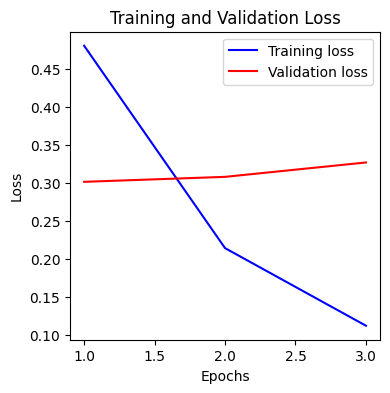

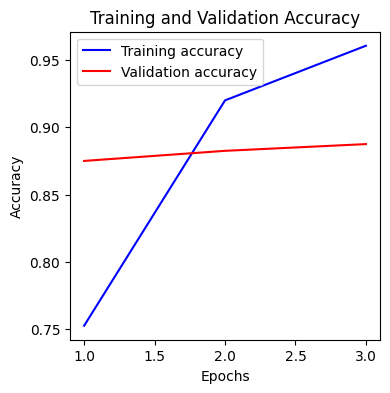

In [ ]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = bert_history.history

# Extract loss and accuracy values for both training and validation
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

# Create a range of epoch numbers for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs') # Ouch... floats as x-ticks?
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(4, 4))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model loading and Evaluation

In [ ]:
# In case you want to load your trained_model

# Model initialization
loaded_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Load the weights from the checkpoint
checkpoint_filepath = 'Demo_DistilBERT_checkpoint.weights.h5'
loaded_model.load_weights(checkpoint_filepath)

# Compile the model with the same optimizer, loss, and metric used during training
# (This is because we'd only saved the model weights)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the test dataset
eval_results = loaded_model.evaluate(ds_test_encoded)

print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

# You can also continue training from here
# number_of_epochs = ...
# bert_history = loaded_model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded, callbacks=[lr_callback, early_stopping_callback, model_checkpoint_callback])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

100/100 [==============================] - 10s 85ms/step - loss: 0.3269 - accuracy: 0.8875
Test Loss: 0.3269083499908447, Test Accuracy: 0.887499988079071


## Summary

1. **Loading and preprocessing the dataset**: The code begins by importing necessary libraries and loading the IMDB movie reviews dataset from TensorFlow Datasets. It preprocesses the dataset by taking a specified number of samples for training and testing, batching, and prefetching for better performance. The data is then decoded and converted into NumPy arrays.

2. **Importing DistilBERT model and tokenizer**: The DistilBERT model is imported using Hugging Face's Transformers library, along with the tokenizer. A custom function `convert_example_to_feature` is defined to tokenize and preprocess the input text using the tokenizer, including adding special tokens, padding, and truncating.

3. **Creating TensorFlow datasets**: Another custom function `encode_examples` is defined to create a TensorFlow dataset from the tokenized and preprocessed input text and labels.

4. **Encoding and batching the datasets**: The training and test datasets are encoded using the `encode_examples` function and batched, with the training dataset also being shuffled.

5. **Compiling the model**: The model is compiled with the Adam optimizer, learning rate 1e-5, and a sparse categorical cross-entropy loss function. A learning rate scheduler with warm-up and linear decay is defined, along with an early stopping and model checkpoint callback.

6. **Fine-tuning and evaluation**: The model is fine-tuned on the training data, and its performance is evaluated on the test data. The best model weights are saved in a checkpoint file. Some plots are also generated

7. **Loading the trained model**: The code also demonstrates how to load a pretrained DistilBERT model and the saved checkpoint file, compile the model with the same optimizer, loss function, and metric, and evaluate the model on the test dataset. This loaded model can be used for further fine-tuning or predictions.



## Tips for fine-tuning

Below is what used:
1. **Learning rate scheduling**: A custom learning rate scheduler with a warm-up phase and linear decay was used. This helps the model gradually adapt to the task-specific data and slowly decrease the learning rate as training progresses.

2. **Early stopping**: Early stopping with a patience of 2 epochs was implemented to prevent overfitting by stopping the training process if there is no improvement in the validation loss for a specified number of epochs.

3. **Model checkpointing**: The best model weights were saved during training based on validation accuracy, enabling the loading of the best-performing model later for further fine-tuning or prediction.


Additional techniques that can be helpful in fine-tuning BERT models:

1. **Gradient clipping**: Gradient clipping can help prevent exploding gradients during training, which can lead to unstable learning dynamics. This can be added to the optimizer as follows:

```
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08, clipnorm=1.0)
```


2. **Weight decay**: Using the AdamW optimizer, which includes weight decay regularization, can help improve the model's generalization by applies a direct modification to the weights by shrinking them towards zero, independent of the adaptive learning rates:

```
from tensorflow.keras.optimizers.experimental import AdamW
optimizer = AdamW(learning_rate=learning_rate, weight_decay=1e-3)
```


3. **Reduce learning rate on plateau**: Instead of using a custom learning rate scheduler, the `ReduceLROnPlateau` callback can be used to automatically reduce the learning rate when the validation loss plateaus:

```
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
```
This callback can then be added to your list of callbacks during model.fit()



## Trainer

Hugging Face's Trainer (https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/trainer) is a high-level, easy-to-use training and evaluation wrapper designed specifically for fine-tuning and training transformer models. It provides a straightforward way to train, fine-tune, and evaluate models on various tasks, while handling most of the underlying complexities, such as data loading, evaluation metrics, and distributed training.

Below is an example:

```
# Define the metric (accuracy)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    learning_rate=3e-5,
    weight_decay=1e-3,
    warmup_steps=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()
```

For serious deep learning models with distributed and mixed-precision training, please consider Hugging Face's accelerate https://huggingface.co/docs/accelerate/index

# GPT-2
# Fine-Tuning an LLM on the Language Model Task Itself

Above we saw how to use transfer learning to adapt an encoder model like DistilBERT to a new task such as sentence classification.

Below we will see an example of how to fine-tune a decoder-based model like GPT-2. We'll be using model's original language model training task, but now using a new dataset.

We'd like to use the DistilGPT-2 model from HuggingFace to generate some text about COVID-19. There is just one problem: this model was pre-trained on text that predates the pandemic and so the model doesn't 'know' anything about COVID.

To remedy this, we will fine tune the model on a dataset of COVID related news articles.

In [ ]:
start_time = time.time()
# Download
dataset_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/cs109b/datasets/covid.zip",
    extract=True)
dataset_path = dataset_path.replace(".zip","")
print("dataset_path:",dataset_path)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

dataset_path: /root/.keras/datasets/covid
Download execution time (mins) 0.007118423779805501


In [ ]:
# Load all the paths to text files
training_data = []
text_files = os.listdir(dataset_path)
training_data.extend([os.path.join(dataset_path,f) for f in text_files])

# Subset your training data for demo, full datset can take a long time to train
subset_data = True
if subset_data:
  training_data = training_data[:300]

# Load the text content
for idx, path in enumerate(training_data):
  # Load text
  with open(path) as file:
    training_data[idx] = file.read()

print("training_data count:",len(training_data))

training_data count: 300


In [ ]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(training_data)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Text:",training_data[data_idx])

Text: Regeneron asks FDA for emergency authorization of its Covid-19 antibody therapy given to Trump last week  (CNN)Regeneron says it has applied to the US Food and Drug Administration for emergency use authorization for its experimental monoclonal antibody therapy, the same antibody cocktail given to President Donald Trump Friday after he was diagnosed with the virus. The biotechnology company confirmed it had submitted the application for the authorization in a statement on its website Wednesday night. "Under our agreement with the U.S. government for the initial doses of REGN-COV2, if an EUA is granted the government has committed to making these doses available to the American people at no cost and would be responsible for their distribution," the statement said. "At this time, there are doses available for approximately 50,000 patients, and we expect to have doses available for 300,000 patients in total within the next few months. Regeneron's experimental antibody treatment is st

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

# Tokenize data
training_data_tokenized = []
for data in training_data:
  tokenized_text = tokenizer.encode(data)
  training_data_tokenized.append(tokenized_text)

print(len(training_data_tokenized))
print(len(training_data_tokenized[0]),training_data_tokenized[0][:20])

Token indices sequence length is longer than the specified maximum sequence length for this model (1611 > 1024). Running this sequence through the model will result in indexing errors


300
593 [31439, 64, 13423, 12319, 481, 307, 14153, 1028, 17670, 11, 475, 481, 1332, 47949, 284, 2987, 16989, 220, 357, 18474]


In [ ]:
# Split into blocks
training_chunks = []
block_size = 100
for tokenized_text in training_data_tokenized:
  for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
      training_chunks.append(tokenized_text[i:i + block_size])

# Generate inputs and labels
inputs = []
labels = []
for ex in training_chunks:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

print("inputs length:",len(inputs))
print("labels length:",len(labels))

inputs length: 3788
labels length: 3788


In [ ]:
print("input:",len(inputs[0]),inputs[0][:20])
print("labels:",len(labels[0]),labels[0][:20])

input: 99 [31439, 64, 13423, 12319, 481, 307, 14153, 1028, 17670, 11, 475, 481, 1332, 47949, 284, 2987, 16989, 220, 357, 18474]
labels: 99 [64, 13423, 12319, 481, 307, 14153, 1028, 17670, 11, 475, 481, 1332, 47949, 284, 2987, 16989, 220, 357, 18474, 8]


In [ ]:
BATCH_SIZE = 12
TRAIN_SHUFFLE_BUFFER_SIZE = len(inputs)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((inputs, labels))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print("train_data",train_data)

train_data <_PrefetchDataset element_spec=(TensorSpec(shape=(12, 99), dtype=tf.int32, name=None), TensorSpec(shape=(12, 99), dtype=tf.int32, name=None))>


In [ ]:
from transformers import TFAutoModelWithLMHead
############################
# Training Params
############################
learning_rate = 3e-5
epsilon=1e-08
clipnorm=1.0
epochs = 30

# Free up memory
K.clear_session()

# Build the model
model = TFAutoModelWithLMHead.from_pretrained("distilgpt2")

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon, clipnorm=clipnorm)
# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile
model.compile(loss=[loss, *[None] * model.config.n_layer],
                  optimizer=optimizer,
                  metrics=[metric])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data, # train_data.take(1000) for testing
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_tf_auto.py:721: FutureWarning: The class `TFAutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `TFAutoModelForCausalLM` for causal language models, `TFAutoModelForMaskedLM` for masked language models and `TFAutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  81912576  
 er)                                                             
                                                                 
Total params: 81912576 (312.47 MB)
Trainable params: 81912576 (312.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
315/315 [==============================] - 121s 328ms/step - loss: 3.5611 - accuracy: 0.3340
Epoch 2/30
315/315 [==============================] - 102s 325ms/step - loss: 3.3356 - accuracy: 0.3553
Epoch 3/30
315/315 [==============================] - 102s 325ms/step - loss: 3.2254 - accuracy: 0.3678
Epoch 4/30
315/315 [==============================] - 102s 324ms/step - loss: 3.1388 - accuracy: 0.3773
Epoch 5/30
315/315 [========================

In [ ]:
# Input text
input_text = "how is covid affecting"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate outout
outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=75,
    top_p=0.80,
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


input_ids tf.Tensor([[ 4919   318 39849   312 13891]], shape=(1, 5), dtype=int32)
Generated text:


'how is covid affecting children? The key is not to politicize the conversation, but to really politicize the conversation."  The study "explained the impact of covid in young children, adolescents and young adults in different settings," said Jenni Wiley, a research assistant professor at the University of Minnesota.  Wiley said the researchers found that Black children were the "'

In [ ]:
# Input text
input_text = "the global pandemic"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')

# Generate outout
outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=75,
    top_p=0.8,
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text:


'the global pandemic," Francis said in a media briefing on Friday. "It is in our national interest to open our economy to the best of our ability and to prevent further spread of this virus in our communities." Francis also said that although he had not personally contracted the virus, he still had a close relationship with the woman.  "I would urge all US citizens to'

# 🚽 Pipelines

| **Task**                     | **Description**                                                                                              | **Modality**    |
|------------------------------|--------------------------------------------------------------------------------------------------------------|-----------------|
| Text classification          | assign a label to a given sequence of text                                                                   | NLP             |
| Text generation              | generate text given a prompt                                                                                 | NLP             |
| Summarization                | generate a summary of a sequence of text or document                                                         | NLP             |

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](https://huggingface.co/docs/transformers/main/en/./main_classes/pipelines).

</Tip>

In [ ]:
from transformers import pipeline

In [ ]:
cls = pipeline('ner')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
cls("Pavlos is one of the teachers here at Harvard")

[{'entity': 'I-PER',
  'score': np.float32(0.9992362),
  'index': 1,
  'word': 'Pa',
  'start': 0,
  'end': 2},
 {'entity': 'I-PER',
  'score': np.float32(0.99177223),
  'index': 2,
  'word': '##v',
  'start': 2,
  'end': 3},
 {'entity': 'I-PER',
  'score': np.float32(0.995366),
  'index': 3,
  'word': '##los',
  'start': 3,
  'end': 6},
 {'entity': 'I-ORG',
  'score': np.float32(0.972195),
  'index': 11,
  'word': 'Harvard',
  'start': 38,
  'end': 45}]

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 65.27 minutes for this notebook to run
